**Connect Colab with Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Loading**

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/DatasetResearch/'
x_train_dir = os.path.join(DATA_DIR, 'XTrain')
y_train_dir = os.path.join(DATA_DIR, 'yTrain')

x_valid_dir = os.path.join(DATA_DIR, 'XVal')
y_valid_dir = os.path.join(DATA_DIR, 'yVal')

x_test_dir = os.path.join(DATA_DIR, 'XTest')
y_test_dir = os.path.join(DATA_DIR, 'yTest')

In [5]:
path, dirs, files = next(os.walk(x_test_dir))
file_count = len(files)
print(file_count)

4


In [7]:
CLASSES = ['unlabeled','road',
               'sky','roadbarricadeorange','roadbarricadewhite','tree','cone','poles']

In [8]:
from torch.utils.data import Dataset as BaseDataset

In [9]:
class Dataset(BaseDataset):
    """TrayDataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        #get images(x) and masks(y) ids
        self.ids_x = sorted(os.listdir(images_dir))
        #['1001a01.jpg', '1005a.jpg', '1006a72.jpg', '2001a72.jpg', '2002a.jpg'] etc.
        self.ids_y = sorted(os.listdir(masks_dir))

        #get images(x) and masks(y) full paths (fps)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_x]
        #'/content/drive/My Drive/Colab Notebooks/TrayDataset/XTest/1001a01.jpg'
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids_y]

        # convert str names to class values on masks
        self.class_values = [CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids_x)
        print(images_dir)

In [10]:
def visualize(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Mask'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")

In [11]:
for label  in CLASSES:
    dataset = Dataset(x_test_dir, y_test_dir, classes=[label])
    image, mask = dataset[2]
    visualize(
        image=image, mask=mask.squeeze(),
        label  = label )

Output hidden; open in https://colab.research.google.com to view.

**Data Augmentation**



In [12]:
import albumentations as albu


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [13]:
def get_training_augmentation():
    train_transform = [

        albu.Resize(256, 416, p=1),
        albu.HorizontalFlip(p=0.5),

        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),

        albu.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 416, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [14]:
# helper function for data visualization
def visualizeData(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

208


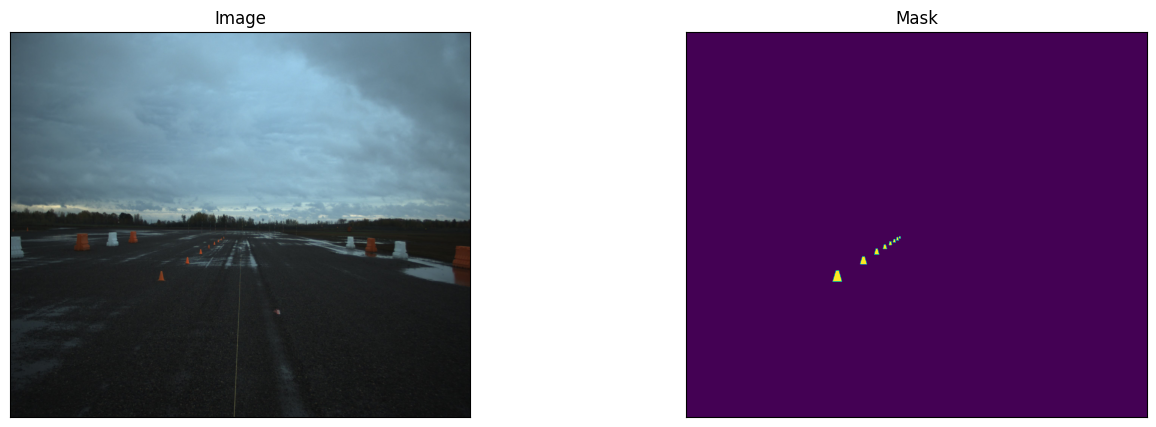

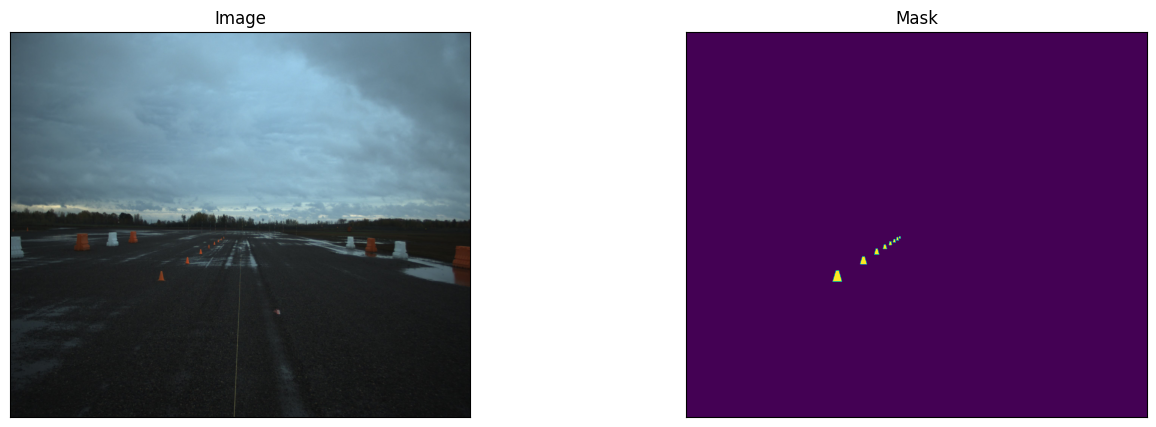

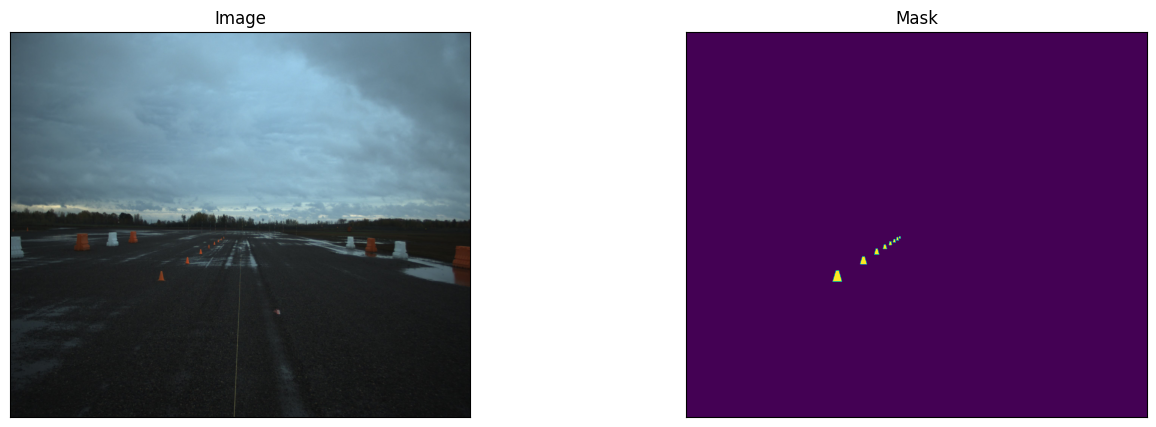

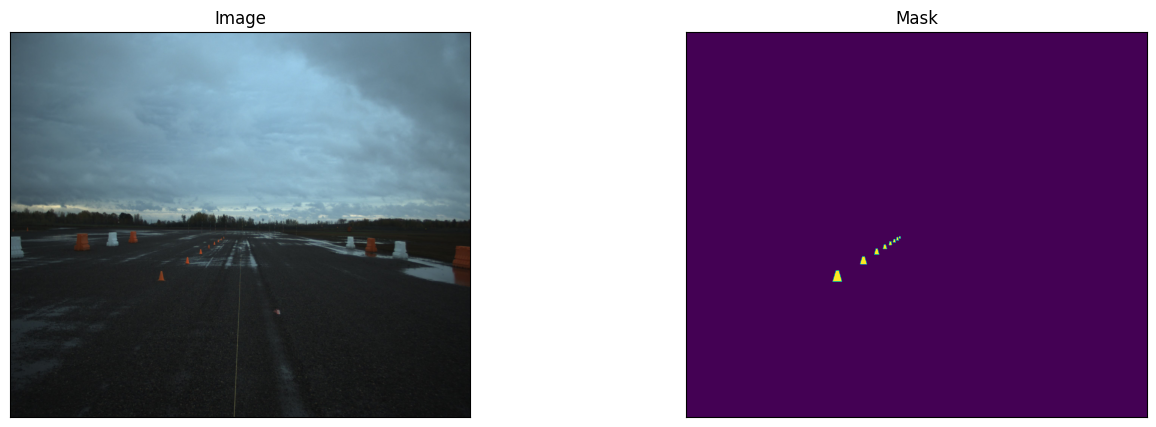

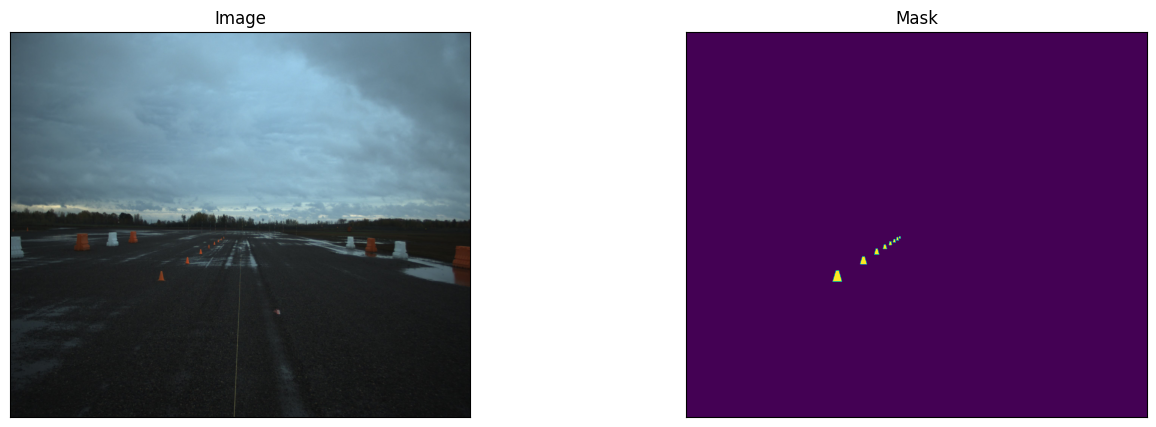

In [ ]:
augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=None,
    classes=['cone'],
)
print(len(augmented_dataset))
# same image with different  transforms
for i in range(5):
    image, mask = augmented_dataset[2]
    visualizeData(image=image, mask=mask.squeeze(-1))

**Define Performance Metrics**

In [15]:

import re
import torch.nn as nn


class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name


class Metric(BaseObject):
    pass


class Loss(BaseObject):
    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError("Loss should be inherited from `Loss` class")

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError("Loss should be inherited from `BaseLoss` class")

    def __rmul__(self, other):
        return self.__mul__(other)


class SumOfLosses(Loss):
    def __init__(self, l1, l2):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)


class MultipliedLoss(Loss):
    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split("+")) > 1:
            name = "{} * ({})".format(multiplier, loss.__name__)
        else:
            name = "{} * {}".format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)
class Activation(nn.Module):

    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == 'identity':
            self.activation = nn.Identity(**params)
        elif name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif name == 'softmax2d':
            self.activation = nn.Softmax(dim=1, **params)
        elif name == 'softmax':
            self.activation = nn.Softmax(**params)
        elif name == 'logsoftmax':
            self.activation = nn.LogSoftmax(**params)
        elif name == 'argmax':
            self.activation = ArgMax(**params)
        elif name == 'argmax2d':
            self.activation = ArgMax(dim=1, **params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError('Activation should be callable/sigmoid/softmax/logsoftmax/None; got {}'.format(name))

    def forward(self, x):
        return self.activation(x)

In [16]:
import torch


def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union


jaccard = iou


def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


def accuracy(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate accuracy score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt == pr, dtype=pr.dtype)
    score = tp / gt.view(-1).shape[0]
    return score


def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score


def recall(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Recall between ground truth and prediction
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: recall score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fn = torch.sum(gt) - tp

    score = (tp + eps) / (tp + fn + eps)

    return score

In [17]:
import torch.nn as nn

class JaccardLoss(Loss):
    def __init__(self, eps=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - jaccard(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )


class DiceLoss(Loss):
    def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - f_score(
            y_pr,
            y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )


class L1Loss(nn.L1Loss, Loss):
    pass


class MSELoss(nn.MSELoss, Loss):
    pass


class CrossEntropyLoss(nn.CrossEntropyLoss, Loss):
    pass


class NLLLoss(nn.NLLLoss, Loss):
    pass


class BCELoss(nn.BCELoss, Loss):
    pass


class BCEWithLogitsLoss(nn.BCEWithLogitsLoss, Loss):
    pass

In [18]:
class IoU(Metric):
    __name__ = "iou_score"

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return iou(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Fscore(Metric):
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return f_score(
            y_pr,
            y_gt,
            eps=self.eps,
            beta=self.beta,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Accuracy(Metric):
    def __init__(self, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return accuracy(
            y_pr,
            y_gt,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Recall(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return recall(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Precision(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return precision(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

In [19]:
metrics = [
    IoU(threshold=0.5),
    Accuracy(threshold=0.5),
    Fscore(threshold=0.5),
    Recall(threshold=0.5),
    Precision(threshold=0.5),
]

**Define Segmentation Deep Learning Models**

In [20]:
#Install and Clone Github segmentation models pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch


  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-cp7oe_cn
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-cp7oe_cn
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit cf50cd082d35763073a296f6ee6378e24938bed8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 761.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import segmentation_models_pytorch as smp

In [ ]:
#https://smp.readthedocs.io/en/latest/encoders.html
#resnext50_32x4d, mit_b2, timm-gernet_s, efficientnet-b3, mobilenet_v2, resnet152, vgg13
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax'

# create segmentation model with pretrained encoder
#Decoders= PAN, PSPNet, MAnet, Linknet, FPN, DeepLabV3, DeepLabV3Plus, Unet
model =smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
#Normalize your data the same way as during encoder weight pre-training
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 171MB/s]


In [ ]:
print(model)

**Model HyperParameters Optimization**

In [ ]:
#Define Optimization algorithm with Learning rate
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

#Define Loss Function
loss = DiceLoss()

**Data Loaders**

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


**Model Training**

In [ ]:
import numpy as np


class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [ ]:
import sys
import torch
from tqdm import tqdm as tqdm

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
train_epoch = TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 100):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Save the model with best iou score

    if i == 15:
        torch.save(model, "/content/drive/My Drive/Colab Notebooks/DeepLabV3Plus15.pth")
        print('Model saved!')
    if i == 20:
        torch.save(model, "/content/drive/My Drive/Colab Notebooks/DeepLabV3Plus20.pth")
        print('Model saved!')
    if i == 25:
        torch.save(model, "/content/drive/My Drive/Colab Notebooks/DeepLabV3Plus25.pth")
        print('Model saved!')
    if i == 30:
        torch.save(model, "/content/drive/My Drive/Colab Notebooks/DeepLabV3Plus30.pth")
        print('Model saved!')
    if i == 40:
        torch.save(model, "/content/drive/My Drive/Colab Notebooks/DeepLabV3Plus40.pth")
        print('Model saved!')
    if i == 45:
        torch.save(model, "/content/drive/My Drive/Colab Notebooks/DeepLabV3Plus45.pth")
        print('Model saved!')




Epoch: 0
train:   0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|██████████| 12/12 [00:31<00:00,  2.62s/it, dice_loss - 0.4287, iou_score - 0.7394, accuracy - 0.9668, fscore - 0.8436, recall - 0.748, precision - 0.979]

Epoch: 1
valid: 100%|██████████| 12/12 [00:15<00:00,  1.32s/it, dice_loss - 0.1357, iou_score - 0.8862, accuracy - 0.9848, fscore - 0.935, recall - 0.9164, precision - 0.9574]

Epoch: 2
valid: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, dice_loss - 0.1204, iou_score - 0.8824, accuracy - 0.9836, fscore - 0.9291, recall - 0.9147, precision - 0.9467]

Epoch: 3
valid: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it, dice_loss - 0.09985, iou_score - 0.8946, accuracy - 0.9855, fscore - 0.9385, recall - 0.9267, precision - 0.9525]

Epoch: 4
valid: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it, dice_loss - 0.09089, iou_score - 0.8942, accuracy - 0.9852, fscore - 0.9382, recall - 0.9291, precision - 0.9485]

Epoch: 5
valid: 100%|██████████| 12/12 [00:15<00:00,  1.31s/it, dice_loss - 0.08506, iou_score - 0.8967, accuracy - 0.98

**Testing the Model**

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation= get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
metrics = [
    IoU(threshold=0.7),
    Accuracy(threshold=0.7),
    Fscore(threshold=0.7),
    Recall(threshold=0.7),
    Precision(threshold=0.7),
]

In [ ]:
Trained_model = torch.load('/content/drive/My Drive/Colab Notebooks/DeepLabV3Plus10No.pth')

In [ ]:
# Evaluate model on test set
test_epoch = ValidEpoch(
    model=Trained_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)
logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it, dice_loss - 0.02611, iou_score - 0.9646, accuracy - 0.9955, fscore - 0.982, recall - 0.9787, precision - 0.9852]


In [ ]:
metrics = [
    IoU(threshold=0.5, ignore_channels=[1,2,3,4,5,6,7]),
    IoU(threshold=0.5, ignore_channels=[0,2,3,4,5,6,7]),
    IoU(threshold=0.5, ignore_channels=[0,1,3,4,5,6,7]),
    IoU(threshold=0.5, ignore_channels=[0,1,2,4,5,6,7]),
    IoU(threshold=0.5, ignore_channels=[0,1,2,3,5,6,7]),
    IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,6,7]),
    IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,7]),
    IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,6]),
]
print(test_epoch.metrics[4])

Precision(
  (activation): Activation(
    (activation): Identity()
  )
)


In [ ]:
test_epoch.metrics[0].__name__="IoU_Class0"
test_epoch.metrics[1].__name__="IoU_Class1"
test_epoch.metrics[2].__name__="IoU_Class2"
test_epoch.metrics[3].__name__="IoU_Class3"
test_epoch.metrics[4].__name__="IoU_Class4"
test_epoch.metrics[5].__name__="IoU_Class5"
test_epoch.metrics[6].__name__="IoU_Class6"
test_epoch.metrics[7].__name__="IoU_Class7"
test_epoch.metrics[8].__name__="IoU_Class8"

AttributeError: ignored

**Visualize Segmentation Results**

In [ ]:
# Evaluate model on test set
test_epoch = ValidEpoch(
    model=Trained_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it, dice_loss - 0.01843, iou_score - 0.9661, accuracy - 0.9957, fscore - 0.9827, recall - 0.9812, precision - 0.9843]


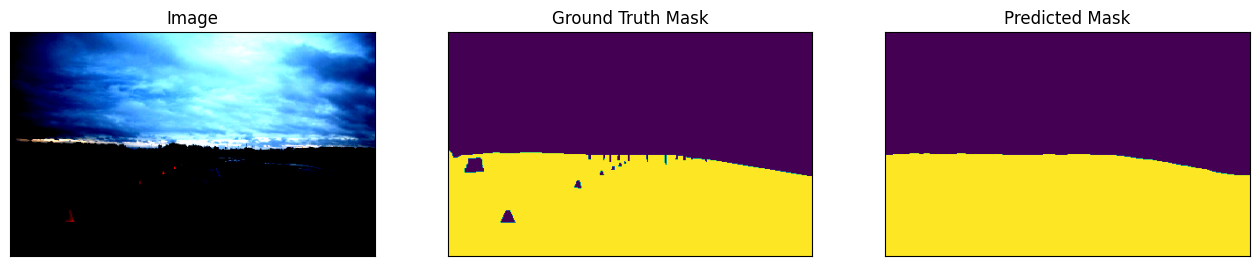

In [ ]:
#Get orignial image and mask from test dataset
image, gt_mask = test_dataset[2]

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
predicted_mask = Trained_model.predict(x_tensor)

pr_mask = (predicted_mask.squeeze().cpu().numpy().round())
pr_mask = pr_mask[1,:,:]
gt_mask = gt_mask[1,:,:]
image_t = image.transpose(1, 2, 0)
visualizeData(
        image=image_t,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )

In [ ]:
#Convert the predicted mask to numpy and get the predicted class indices
predicted_output = torch.argmax(predicted_mask.squeeze(), dim=0).detach().cpu().numpy()
Indices = np.unique(predicted_output)

for i in Indices:
  print(CLASSES[i])


road
sky
tree


In [ ]:
# Define function to convert 2D segmentation to RGB Image
def decode_segmentation_map(image, classesLength=43):

  Class_label_colors = np.array([
#Background,     tray        cutlery
(0, 0, 0),(75, 65, 50), (100, 127, 150),(255, 86, 0),(255, 255, 255),(0, 100, 0),
(0, 255, 0),(255, 0, 0),(0, 250, 0),(180, 0, 0),
(100, 100, 0),(128, 0, 100),(100, 128, 0),(0, 100, 128),(100, 0, 100),
(150, 100, 0),(0, 100, 200), (100, 50, 50),(50, 100, 250),(100, 250, 50),(180, 100, 0),
(100, 50, 218),(200, 128, 100),(100, 0, 128),(10, 100, 128),(100, 150, 75),
(175, 100, 90),(30, 100, 128),(100, 250, 125),(50, 10, 50), (175, 10, 175),(25, 225, 50),
(100, 128, 218),(128, 0, 100),(128, 128, 0),(90, 100, 0),(100, 200, 0),(175, 100, 150),
(200, 100, 200),(200, 50, 50),(250, 100, 50),(100, 25, 50),(150, 100, 100)
])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, classesLength):
    idx = image == l
    r[idx] = Class_label_colors[l, 0]
    g[idx] = Class_label_colors[l, 1]
    b[idx] = Class_label_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

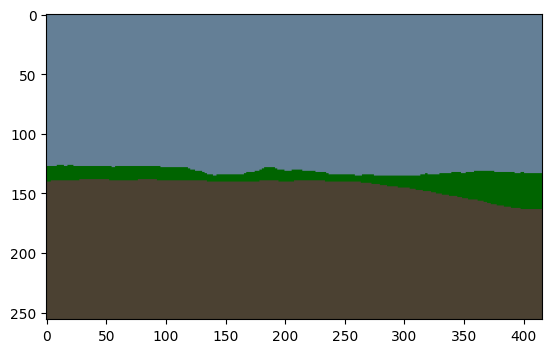

In [ ]:
rgb_map = decode_segmentation_map(predicted_output,43)
plt.imshow(rgb_map);